In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from utils import preprocess_image

2023-07-11 22:10:56.442493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_path = '../tflite_models/float32/yolox.tflite'
img_path = './images/street.jpg'

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
img_shape = tuple(input_shape[1:3])
img_type = input_details[0]['dtype']
print(img_shape, img_type)

(416, 416) <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
scaled_img, original_img = preprocess_image(img_path, img_shape)

In [5]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)

In [6]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [7]:
print("IN: ", scaled_img.shape)
print("OUT: ", output_data.shape)
bboxes = output_data[:, 0:4]
probability = output_data[:, 4]
class_id = output_data[:, 5]

IN:  (1, 416, 416, 3)
OUT:  (148, 6)


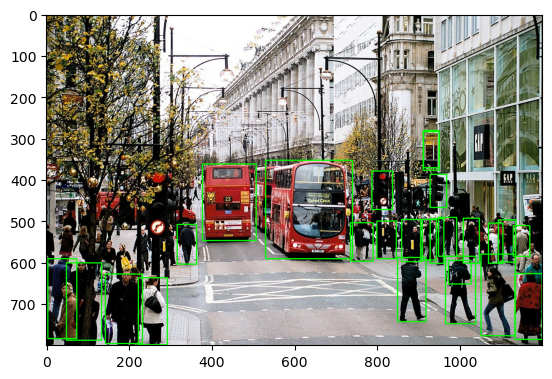

In [8]:
for box in bboxes:
    x1, y1, x2, y2 = box
    x1_ratio = x1 / input_shape[1]
    y1_ratio = y1 / input_shape[2]
    x2_ratio = x2 / input_shape[1]
    y2_ratio = y2 / input_shape[2]
    cv2.rectangle(original_img, (int(x1_ratio * original_img.shape[1]), int(y1_ratio * original_img.shape[0])), (int(x2_ratio * original_img.shape[1]), int(y2_ratio * original_img.shape[0])), (0, 255, 0), 2)

plt.imshow(original_img)
